In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shutil

In [2]:
# Load the CSV file containing food information
csv_path = "C:/Users/Surya/Downloads/CODECRAFT_ML_05/indian_food.csv"
data = pd.read_csv(csv_path)


In [3]:
# Check the columns to find the correct ones for image paths and labels
print(data.columns)  # Make sure to inspect the columns

Index(['name', 'ingredients', 'diet', 'prep_time', 'cook_time',
       'flavor_profile', 'course', 'state', 'region'],
      dtype='object')


In [4]:
# We will now assume that the image paths are stored in the directory 
# structure and the labels are "food" and "non_food".

# Define the directory paths for training, validation, and evaluation
base_dir = "C:/Users/Surya/Downloads/CODECRAFT_ML_05/archive (3)/"


In [5]:
train_dir = os.path.join(base_dir, "training")
val_dir = os.path.join(base_dir, "validation")
eval_dir = os.path.join(base_dir, "evaluation")

In [6]:
# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load image with target size
    img_array = img_to_array(img)  # Convert image to numpy array
    return img_array / 255.0  # Normalize the image to [0, 1] range

In [7]:
def prepare_dataset(directory):
    images = []
    labels = []
    
    # Loop through the 'food' and 'non_food' directories
    for label in ['food', 'non_food']:
        label_dir = os.path.join(directory, label)
        
        # Loop through each image file in the directory
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            # Preprocess image
            image = preprocess_image(img_path)
            images.append(image)
            # Append the corresponding label (0 for non_food, 1 for food)
            labels.append(1 if label == 'food' else 0)
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels



In [8]:
# Load training, validation, and evaluation data
X_train, y_train = prepare_dataset(train_dir)
X_val, y_val = prepare_dataset(val_dir)
X_eval, y_eval = prepare_dataset(eval_dir)

In [9]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_eval = to_categorical(y_eval, num_classes=2)

In [10]:

# Define the model using a pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
# Freeze the layers of the pre-trained model to avoid retraining them
base_model.trainable = False

In [12]:
# Build the complete model
model = Sequential([
    base_model,  # Add the pre-trained model
    GlobalAveragePooling2D(),  # Pooling layer to reduce spatial dimensions
    Dense(256, activation='relu'),  # Fully connected layer with ReLU activation
    Dense(2, activation='softmax')  # Output layer with softmax for binary classification (food vs. non_food)
])

In [13]:
# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Print the model summary to check the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))


94/94 [==============================] - 1248s 13s/step - loss: 0.3181 - accuracy: 0.8647 - val_loss: 0.1702 - val_accuracy: 0.9390


In [16]:
# Evaluate the model on the evaluation data
val_loss, val_accuracy = model.evaluate(X_eval, y_eval)
print(f"Evaluation Loss: {val_loss}")
print(f"Evaluation Accuracy: {val_accuracy}")

32/32 [==============================] - 125s 4s/step - loss: 0.2007 - accuracy: 0.9220
Evaluation Loss: 0.20066525042057037
Evaluation Accuracy: 0.921999990940094


In [17]:
# Optionally, save the trained model
model.save('food_non_food_classification_model.h5')


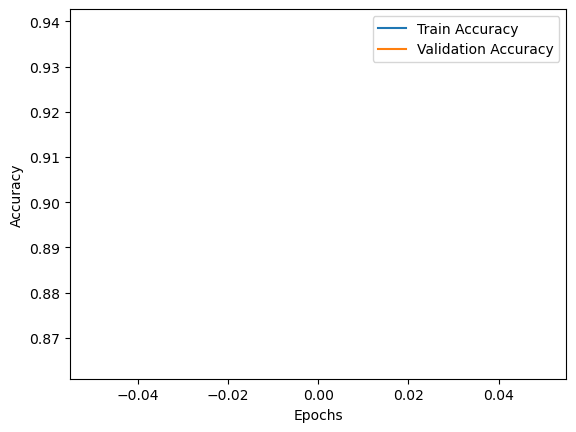

In [18]:
# Optionally, you can visualize the training progress (loss, accuracy) during training
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

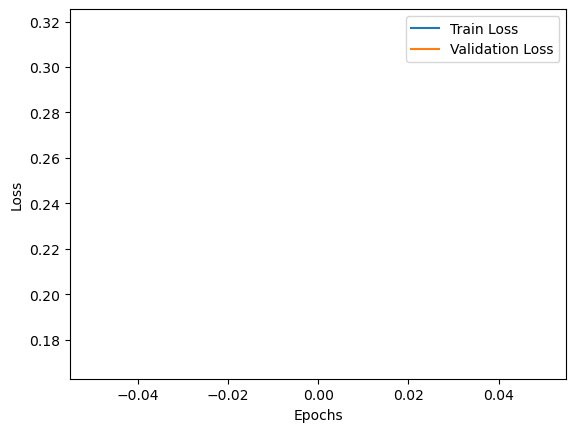

In [19]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()